### Import libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage.feature import hog

### Data loading & checking

#### Read dataset from drive

In [ ]:
images = []
labels = []

root_path = "C:\\Users\\HP\\IPCV_Assignment\\PokemonData"
for subdir, dirs, files in os.walk(root_path):
    for filename in files:
        path = os.path.join(subdir, filename)
        image = cv2.imread(path)
        label = path.split('\\')[-2]
        images.append(image)
        labels.append(label)

#### Put data into dataframe

In [ ]:
df = pd.DataFrame({'Image':images, 'Label':labels})
df.head()

,Image,Label
0,"[[[140, 119, 251], [140, 120, 249], [144, 121,...",Abra
1,"[[[172, 151, 120], [172, 151, 120], [172, 151,...",Abra
2,"[[[221, 153, 64], [219, 152, 60], [218, 151, 5...",Abra
3,"[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",Abra
4,"[[[193, 204, 208], [203, 214, 218], [204, 215,...",Abra


#### Visualize some examples

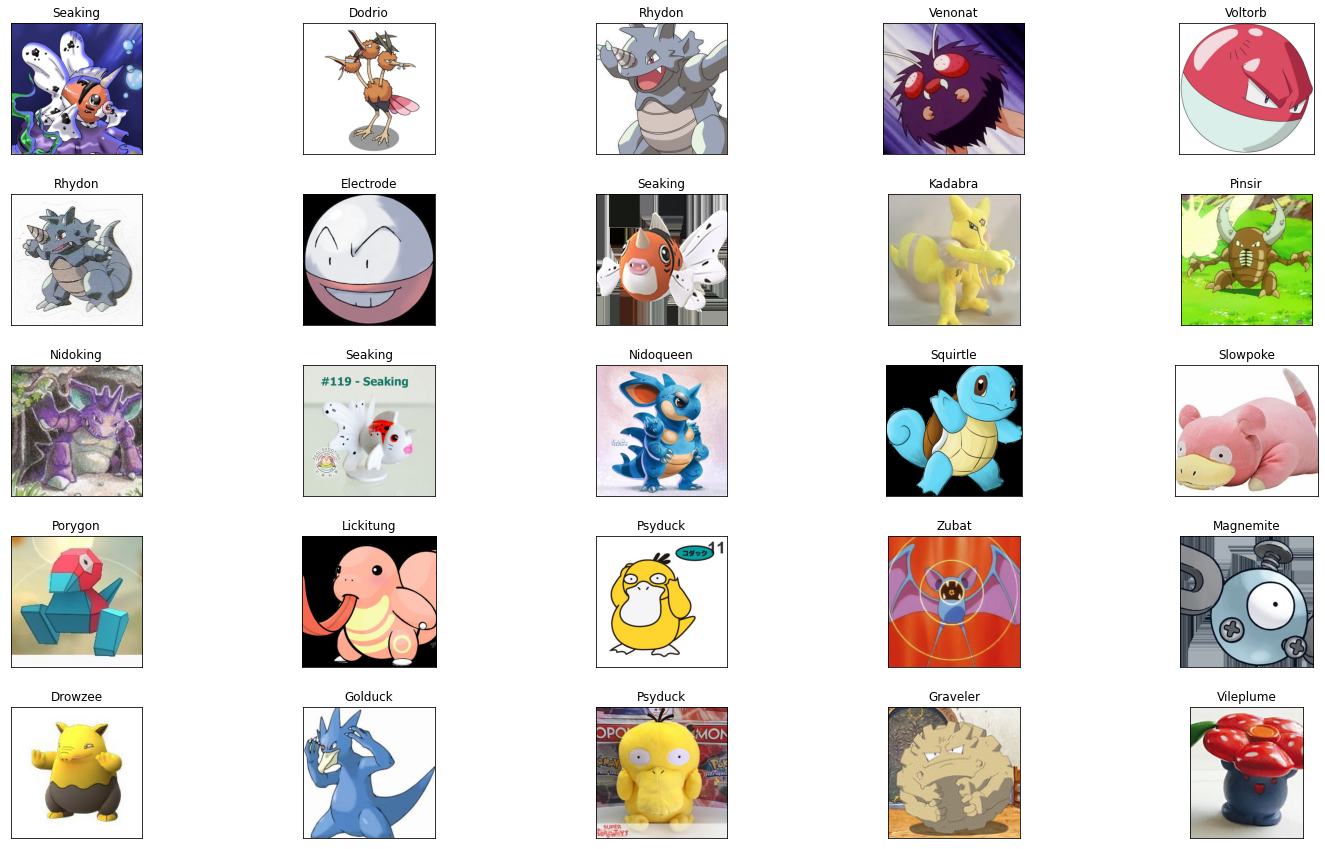

In [ ]:
def plot_image(images, labels):
    plt.figure(1 , figsize = (25 , 15))
    n = 0
    for i in range(25):
        n += 1
        r = np.random.randint(0 , images.shape[0] , 1)

        plt.subplot(5 , 5 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(cv2.cvtColor(images[r[0]], cv2.COLOR_BGR2RGB))

        plt.title(labels[r[0]])
        plt.xticks([])
        plt.yticks([])

    plt.show()

images = np.array(images)
labels = np.array(labels)
plot_image(images, labels)

The dataset contains images from various media, including cartoon, paper cards, hand-drawn art and also video games.

#### Data overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6837 entries, 0 to 6836
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   6825 non-null   object
 1   Label   6837 non-null   object
dtypes: object(2)
memory usage: 107.0+ KB


#### Check for null values

In [ ]:
df.isnull().sum()

Image    12
Label     0
dtype: int64

#### Drop all rows with null

In [ ]:
df.dropna(inplace = True)

#### Check distribution of pokemon

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215065FD5B0>]],
      dtype=object)

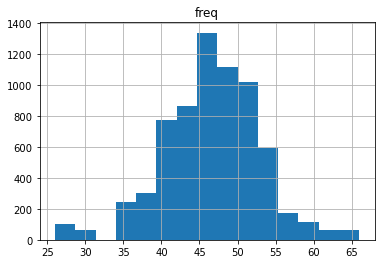

In [ ]:
df['freq'] = df.groupby('Label')['Label'].transform('count')
df.hist(column='freq', bins=15)

To get the final value, divide total number (y) by freq (x). Most of the pokemon classes have 40 to 50 images each.

### Data preparation & preprecessing

#### Resize images and convert to grayscale

In [ ]:
images_resized = []
for image in images:
    try:
        images_resized.append(cv2.resize((cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)), (64,128), interpolation = cv2.INTER_AREA))
    except Exception as e:
        pass

#### Choosing feature extraction algorithm
Two algorithms are used for comparison here, namely SIFT (Scale Invariant Feature Transform) on the right and ORB (Oriented Fast & BRIEF) on the left

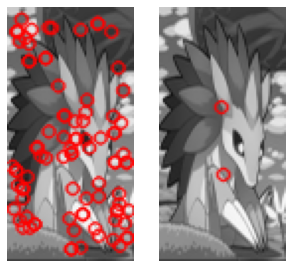

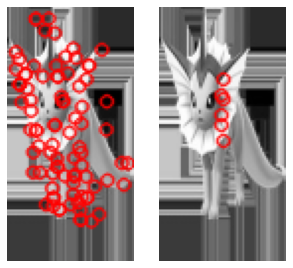

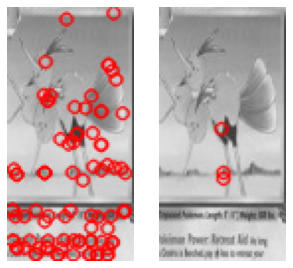

In [ ]:
import random
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

for img in random.choices(images_resized, k=3):
    fig = plt.figure(figsize=(5,10))
    keypoints1, descriptors1 = sift.detectAndCompute(img, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img, None)
    img_kp1 = cv2.drawKeypoints(img, keypoints1, cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(255, 0, 0))
    img_kp2 = cv2.drawKeypoints(img, keypoints2, cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(255, 0, 0))
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.imshow(img_kp1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.imshow(img_kp2)

We see that SIFT is able to extract much more features compared to ORB. This is because SIFT computes Histogram of Oriented Gradient whereas ORB finds any sudden change in the intensity or corners. Thus, SIFT would be better in detecting the shape of an object, or pokemon in our case.

#### Feature extraction using HOG

Next, we will test out a simpler algorithm called HOG (Histogram of Oriented Gradient), which is the same algorithm that SIFT extends upon. Though SIFT is a more enhanced version and would perform better, the amount of post-processing and computation time is too much. Thus, HOG is used here instead.

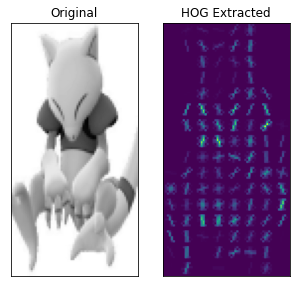

In [ ]:
image = images_resized[5]
features ,hog_image = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm='L2',visualize=True)

plt.figure(figsize = (5,10))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hog_image), plt.title('HOG Extracted')
plt.xticks([]), plt.yticks([])
plt.show()

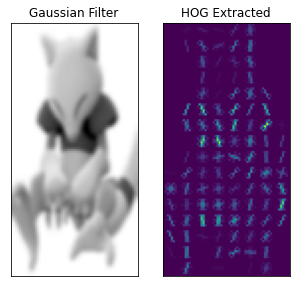

In [ ]:
blur = cv2.GaussianBlur(image, (5, 5),0)
features ,hog_image = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm='L2',visualize=True)

plt.figure(figsize=(5,10))
plt.subplot(121), plt.imshow(blur, cmap='gray'), plt.title('Gaussian Filter')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hog_image), plt.title('HOG Extracted')
plt.xticks([]), plt.yticks([])
plt.show()

There is not much difference in the result extracted from the original image and Gaussian blurred image so filter will not be necessary. Note that in the comparison earlier, no blurring was applied because both algorithms already come with Gaussian blur.

### Binary Classification & PCA

After that, we try out different classifier algorithms to see which one would perform the best. Since this is just for testing purposes, we will just use binary classification along with PCA (Principal Component Analysis) to visualize and understand better.

In [ ]:
sample = ['Jolteon', 'Pikachu']
df_sample = df[df['Label'].isin(sample)]
df_sample['Label'] = df_sample['Label'].map({'Jolteon': 0, 'Pikachu': 1})
hog_features = []

<ipython-input-13-f933ba92ca70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['Label'] = df_sample['Label'].map({'Jolteon': 0, 'Pikachu': 1})


We choose to use Jolteon and Pikachu because both classes have more images and they also look similar to each other in terms of color and shape.

#### Import models and metrics

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from mlxtend.plotting import plot_decision_regions

####

In [ ]:
for i in df_sample.index:
    image = cv2.resize((cv2.cvtColor(df_sample['Image'][i], cv2.COLOR_BGR2GRAY)), (64,128), interpolation = cv2.INTER_AREA)
    features ,hog_image = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm='L2',visualize=True)
    hog_features.append(features)

hog_features = np.array(hog_features)
x, x_test, y, y_test = train_test_split(hog_features,df_sample['Label'],test_size=0.2,stratify=df_sample['Label'], random_state=42)

pca = PCA(n_components = 2)
x2 = pca.fit_transform(x)
x2_test = pca.transform(x_test)

#### K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x, y)
result = classification_report(y_test, knn.predict(x_test))
print(result)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.77      0.77      0.77        13

    accuracy                           0.74        23
   macro avg       0.73      0.73      0.73        23
weighted avg       0.74      0.74      0.74        23



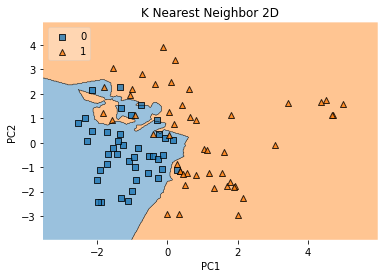

0.8260869565217391


In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(x2, y)

plot_decision_regions(x2, np.array(y), clf=clf, legend=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K Nearest Neighbor 2D')
plt.show()

print(clf.score(x2_test, y_test))

With PCA, the result improves slightly by 10%.

#### Naive Bayes

In [ ]:
naive = MultinomialNB()
naive.fit(x, y)
result = classification_report(y_test, naive.predict(x_test))
print(result)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.92      0.96        13

    accuracy                           0.96        23
   macro avg       0.95      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



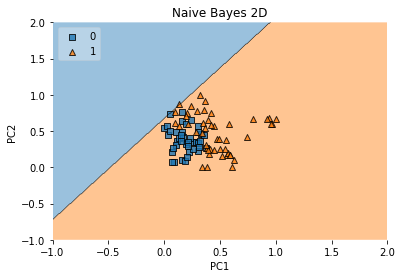

0.8695652173913043


In [ ]:
scaler = MinMaxScaler()
x2_scaled = scaler.fit_transform(x2)

clf = MultinomialNB()
clf.fit(x2_scaled, y)
plot_decision_regions(x2_scaled, np.array(y), clf=clf, legend=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Naive Bayes 2D')
plt.show()

print(clf.score(x2_test, y_test))

With PCA, the result worsens slightly by 10%.

#### Random Forest

In [ ]:
forest = RandomForestClassifier(n_estimators=200,criterion='entropy')
forest.fit(x, y)
result = classification_report(y_test, forest.predict(x_test))
print(result)

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.80      0.62      0.70        13

    accuracy                           0.70        23
   macro avg       0.71      0.71      0.70        23
weighted avg       0.72      0.70      0.70        23



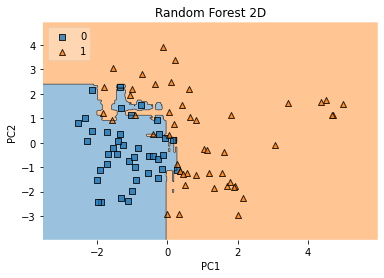

0.7391304347826086


In [ ]:
clf = RandomForestClassifier(n_estimators=200,criterion='entropy')
clf.fit(x2, y)

plot_decision_regions(x2, np.array(y), clf=clf, legend=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Random Forest 2D')
plt.show()

print(clf.score(x2_test, y_test))

Result does not change with PCA.

#### Support Vector Machine

In [ ]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(x, y)
result = classification_report(y_test, svm.predict(x_test))
print(result)

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.86      0.92      0.89        13

    accuracy                           0.87        23
   macro avg       0.87      0.86      0.87        23
weighted avg       0.87      0.87      0.87        23



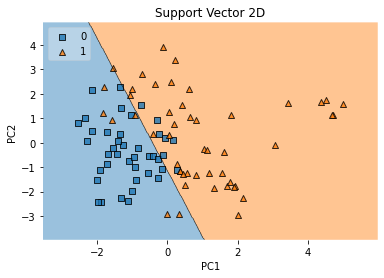

0.8695652173913043


In [ ]:
clf = SVC(gamma='auto', kernel='linear', probability=True)
clf.fit(x2, y)

plot_decision_regions(x2, np.array(y), clf=clf, legend=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Support Vector 2D')
plt.show()

print(clf.score(x2_test, y_test))

Result does not change with PCA.

Overall, all models give good results and high accuracy when classifying two pokemons. Besides this, PCA does not seem to improve the performance by much.

### Model Building

In [ ]:
hog_features_all = []
hog_images_all = []

for image in images_resized:
    features, hog_image = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm='L2',visualize=True)
    hog_features_all.append(features)
    hog_images_all.append(hog_image)

hog_features_all = np.array(hog_features_all)
hog_features_all.shape

(6825, 3360)

Features extracted for every image in the whole dataset. Each image produces about 3000 features.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(hog_features_all,df['Label'],test_size=0.3,stratify=df['Label'],random_state=42)
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

Split into training set and testing set. Also, scaling is applied to reduce computation time.

#### Linear Support Vector Machine

In [ ]:
lsvc = LinearSVC(max_iter=1000)
lsvc.fit(X_train, Y_train)
result = classification_report(Y_test, lsvc.predict(X_test))
print(result)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                  precision    recall  f1-score   support

            Abra       0.22      0.20      0.21        10
      Aerodactyl       0.14      0.09      0.11        11
        Alakazam       0.27      0.38      0.32         8
Alolan Sandslash       0.36      0.33      0.35        12
           Arbok       0.50      0.50      0.50        12
        Arcanine       0.14      0.17      0.15        12
        Articuno       0.22      0.14      0.17        14
        Beedrill       0.57      0.40      0.47        10
      Bellsprout       0.30      0.25      0.27        12
       Blastoise       0.33      0.23      0.27        13
       Bulbasaur       0.62      0.42      0.50        12
      Butterfree       0.62      0.62      0.62         8
        Caterpie       0.29      0.36      0.32        11
         Chansey       0.50      0.46      0.48        13
       Charizard       0.08      0.10      0.09        10
      Charmander       0.37      0.47      0.41        15
      Charmel

#### K Nearest Neighbors

In [ ]:
ovr = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
ovr.fit(X_train, Y_train)
result = classification_report(Y_test, ovr.predict(X_test))
print(result)

                  precision    recall  f1-score   support

            Abra       0.00      0.00      0.00        10
      Aerodactyl       1.00      0.09      0.17        11
        Alakazam       0.50      0.12      0.20         8
Alolan Sandslash       0.67      0.17      0.27        12
           Arbok       0.75      0.25      0.38        12
        Arcanine       1.00      0.17      0.29        12
        Articuno       1.00      0.07      0.13        14
        Beedrill       0.40      0.20      0.27        10
      Bellsprout       0.00      0.00      0.00        12
       Blastoise       0.00      0.00      0.00        13
       Bulbasaur       1.00      0.42      0.59        12
      Butterfree       0.83      0.62      0.71         8
        Caterpie       0.80      0.36      0.50        11
         Chansey       1.00      0.15      0.27        13
       Charizard       1.00      0.10      0.18        10
      Charmander       0.89      0.53      0.67        15
      Charmel

C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy from both models are very low despite having modified the algorithms to be One-VS-Rest, which should make them fit better for multi-class classification problems involving more than 10 classes.

#### XGBoost with PCA

#### Reduce the dimensions by approximately half

In [ ]:
pca = PCA(n_components = 1500)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100)
model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
pred = model.predict(X_test)
pred = le.inverse_transform(pred)
result = classification_report(Y_test, pred)
print(result)

                  precision    recall  f1-score   support

            Abra       0.08      0.10      0.09        10
      Aerodactyl       0.00      0.00      0.00        11
        Alakazam       0.00      0.00      0.00         8
Alolan Sandslash       0.33      0.17      0.22        12
           Arbok       0.31      0.42      0.36        12
        Arcanine       0.00      0.00      0.00        12
        Articuno       0.14      0.14      0.14        14
        Beedrill       0.12      0.20      0.15        10
      Bellsprout       0.22      0.17      0.19        12
       Blastoise       0.00      0.00      0.00        13
       Bulbasaur       0.27      0.25      0.26        12
      Butterfree       0.29      0.50      0.36         8
        Caterpie       0.00      0.00      0.00        11
         Chansey       0.09      0.08      0.08        13
       Charizard       0.00      0.00      0.00        10
      Charmander       0.06      0.07      0.06        15
      Charmel

XGBoost is a gradient boosted algorithm and is used here as our final resort to see if we can make any improvement. However, it only makes the accuracy worse and takes more time to be trained.

### Conclusion

Machine learning algorithms fall short when it comes to multi-class classification involving more than 50 classes. Deep learning is required for such circumstance and neural networks such as CNN (Convolutional Neural Network) should be used.